In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv(r"C:\Users\Dell\gitproject\Energy_Demand_Forecasting\data\processed\Energy Consumption Cleaned.csv")

In [5]:
df['Date'] = pd.to_datetime(df['Date'])


In [7]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
df.head()

,States,Regions,latitude,longitude,Date,Energy Consumption
0,Punjab,NR,31.519974,75.980003,2019-02-01,119.9
1,Haryana,NR,28.450006,77.019991,2019-02-01,130.3
2,Rajasthan,NR,26.449999,74.639981,2019-02-01,234.1
3,Delhi,NR,28.669993,77.230004,2019-02-01,85.8
4,UP,NR,27.599981,78.050006,2019-02-01,313.9


In [13]:
# Sort data by state and date
df = df.sort_values(['States', 'Date']).reset_index(drop=True)


In [15]:
print(df.head())

           States Regions   latitude  longitude       Date  Energy Consumption
0  Andhra Pradesh      SR  14.750429  78.570026 2019-01-07               164.3
1  Andhra Pradesh      SR  14.750429  78.570026 2019-01-08               197.0
2  Andhra Pradesh      SR  14.750429  78.570026 2019-01-09               153.8
3  Andhra Pradesh      SR  14.750429  78.570026 2019-01-10               155.4
4  Andhra Pradesh      SR  14.750429  78.570026 2019-01-11               154.9


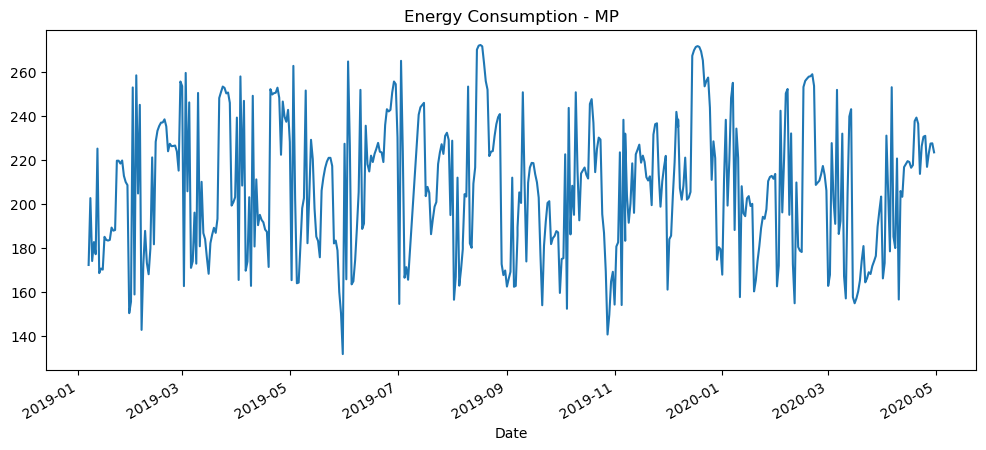

In [17]:
state = 'MP'  # example state, replace as needed
state_data = df[df['States'] == state].set_index('Date')['Energy Consumption']

# Visualize
state_data.plot(figsize=(12,5), title=f'Energy Consumption - {state}')
plt.show()


In [19]:
train = state_data[:-30]
test = state_data[-30:]


In [25]:
import pmdarima as pm

# auto_arima to find best parameters (seasonality=7 for weekly)
auto_model = pm.auto_arima(train, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=4.04 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=4374.163, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4261.666, Time=0.90 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=4302.091, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6089.602, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=4264.078, Time=0.47 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=4258.077, Time=2.69 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=4269.950, Time=2.71 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=4260.108, Time=1.02 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=4366.895, Time=1.87 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=4230.904, Time=3.37 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=4231.131, Time=1.71 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=4248.721, Time=3.06 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=4232.732, Time=2.49 sec
 ARIMA(3,0,0)(2,0,0)[7] intercept   : 

In [26]:
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
model_fit = model.fit(disp=False)
print(model_fit.summary())


                                     SARIMAX Results                                     
Dep. Variable:                Energy Consumption   No. Observations:                  450
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2108.915
Date:                           Fri, 16 May 2025   AIC                           4227.829
Time:                                   17:02:24   BIC                           4248.286
Sample:                                        0   HQIC                          4235.898
                                           - 450                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4799      0.046     10.520      0.000       0.390       0.569
ma.L1         -0.9948      0.037    -27.022

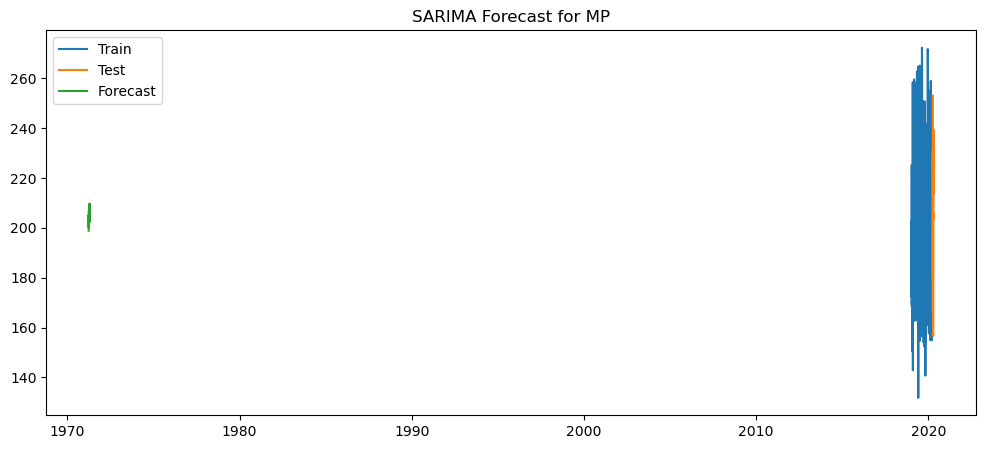

RMSE: 24.00


In [28]:
forecast = model_fit.forecast(steps=30)
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast.index, forecast, label='Forecast')
plt.title(f'SARIMA Forecast for {state}')
plt.legend()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'RMSE: {rmse:.2f}')


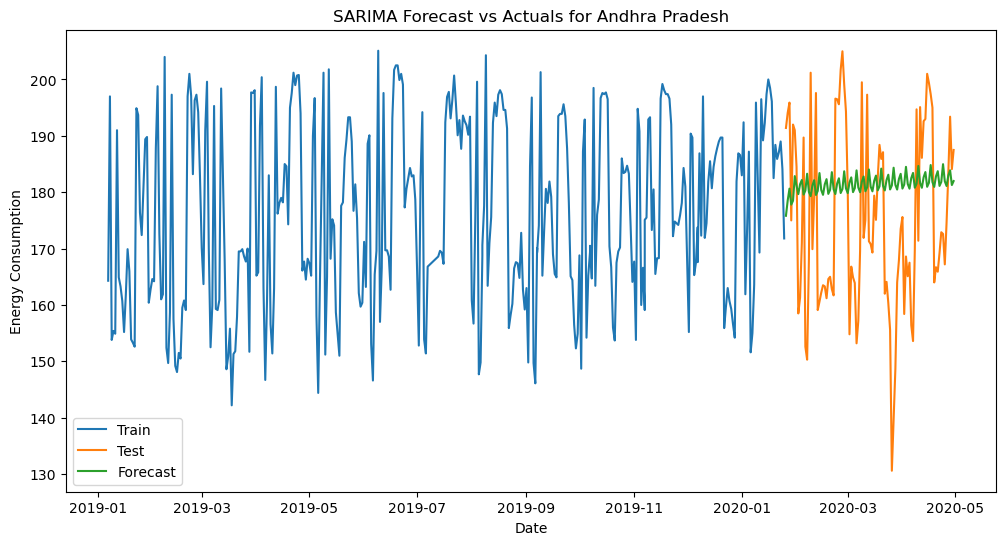

In [43]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define SARIMA parameters (can tune later)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)  # Weekly seasonality

# Dictionary to store metrics
sarima_metrics = {}

# Loop through all states
for state_name in df['States'].unique():
    state_df = df[df['States'] == state_name].sort_values('Date')
    state_df.set_index('Date', inplace=True)

    ts = state_df['Energy Consumption']

    # Split train/test
    train_size = int(len(ts) * 0.8)
    train, test = ts.iloc[:train_size], ts.iloc[train_size:]

    try:
        # Train SARIMA
        start_train = time.time()
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
        sarima_fit = model.fit(disp=False)
        end_train = time.time()

        # Predict
        start_pred = time.time()
        forecast = sarima_fit.forecast(steps=len(test))
        end_pred = time.time()

        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mae = mean_absolute_error(test, forecast)
        mape = np.mean(np.abs((test - forecast) / test)) * 100
        r2 = r2_score(test, forecast)

        # Save metrics
        sarima_metrics[state_name] = {
            'RMSE': rmse,
            'MAE': mae,
            
            'R2': r2,
    
        }

        # Plot only for first state as example
        if state_name == df['States'].unique()[0]:
            plt.figure(figsize=(12, 6))
            plt.plot(train.index, train, label='Train')
            plt.plot(test.index, test, label='Test')
            plt.plot(test.index, forecast, label='Forecast')
            plt.title(f'SARIMA Forecast vs Actuals for {state_name}')
            plt.xlabel('Date')
            plt.ylabel('Energy Consumption')
            plt.legend()
            plt.show()

    except Exception as e:
        print(f"Failed to model {state_name}: {e}")
        continue


In [44]:

# Create DataFrame of all metrics
sarima_metrics_df = pd.DataFrame(sarima_metrics).T
display(sarima_metrics_df)


,RMSE,MAE,R2
Andhra Pradesh,17.527244,15.288213,-0.198403
Arunachal Pradesh,0.234493,0.159643,-0.025084
Assam,4.477475,3.388206,-0.031772
Bihar,17.269292,12.504671,-0.342344
Chandigarh,1.309733,1.055816,-0.024671
Chhattisgarh,9.041706,7.605624,0.046435
DNH,4.637065,2.014236,-0.061015
Delhi,29.212639,24.857693,-0.023200
Goa,1.635135,1.271753,-0.042693
Gujarat,39.916238,30.448790,0.001968


In [51]:
sarima_metrics_df.to_csv("sarima_metrics_summary.csv", index=True)
